In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

In [2]:
data_dir = 'data/'
data_files = ["BH016-1_2GyroidPDMS-Dev_F200_coated_08_04_2024_Stability_in _gasToluene_Freq_stab_120sccm3X_5VPowerBank.txt",
              "SS123-3_1-Dev_F200_coated_08_02_2024_Stability_in_gas_Toluene_Freq_stab_120sccm3X_5VPowerbank.txt"]
            #   "SS123-3_1-Dev_F200_coated_03_12_2025_in_gasToluene_Freq_stab_120sccm10min1X_5VPowerSupply.txt",

In [3]:
datasets = []
for file in data_files:
    df = pd.read_csv(data_dir+file,sep ='\t',engine='python',header=1,skipfooter=1)
    df['datetime'] = pd.to_datetime(df['Time [ms]'],unit='ms')
    df = df.set_index('datetime')
    datasets.append(df)


print(df)

                         Time [ms]  Frequency [Hz]
datetime                                          
1970-01-01 00:00:01.529       1529      384822.247
1970-01-01 00:00:05.474       5474      384822.073
1970-01-01 00:00:05.527       5527      384822.279
1970-01-01 00:00:05.579       5579      384822.260
1970-01-01 00:00:05.626       5626      384822.048
...                            ...             ...
1970-01-01 05:14:02.339   18842339      384905.853
1970-01-01 05:14:02.390   18842390      384905.925
1970-01-01 05:14:02.443   18842443      384905.856
1970-01-01 05:14:02.492   18842492      384905.496
1970-01-01 05:14:02.546   18842546      384905.707

[367164 rows x 2 columns]


3


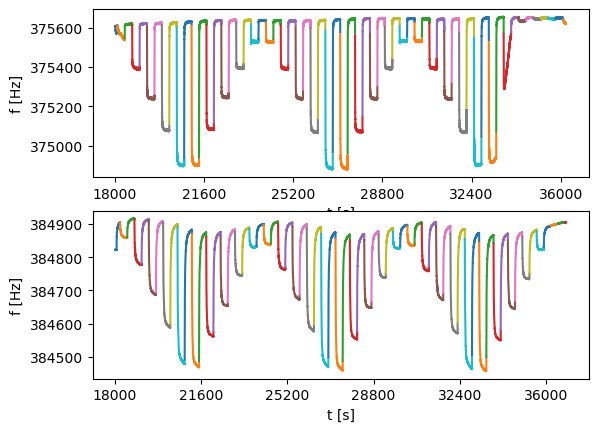

In [4]:
def resample2numpy(df,ax,offset):
    # df['period'] = 0
    y = df.resample('5.002min',label='left',offset=offset)
    # print(df.index.to_period('5m'))
    i = 1

    load = []
    unload = []

    for sample in y:
        time_interval = sample[0]
        group = sample[1]
        # print(df.iloc[group.index])
        out = group.to_numpy(dtype='float64',copy=True)
        # print(out)
        if divmod(i,2)[1]==1:
            unload.append(out)
        else:
            load.append(out)
        i += 1
        # print(sample[1])
        # print(sample[1]['Frequency [Hz]'][0])
        # print()
        # plt.plot(group['index'].sub(group['index'].min()),group['Frequency [Hz]'])
        ax.plot(group['Frequency [Hz]'])
    # print(y.max())
    # print(type(y))
    # plt.xlim([0,6000])
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%s'))
    ax.set_xlabel('t [s]')
    ax.set_ylabel('f [Hz]')
    # ax.set_xlim((0.18,0.185))
    # ax.set_ylim((375500,375700))
    return ax,load,unload


fig,axs = plt.subplots(len(datasets),1)
offsets = ['1.502min','3.48min']
# print()
output = [resample2numpy(df,ax,offset) for (df,ax,offset) in zip(datasets,axs,offsets)]
print(len(output[0]))
plt.show()

4
5
(24178, 2)
(24213, 2)
(24273, 2)
(24240, 2)
(24143, 2)
5
(23433, 2)
(23413, 2)
(23415, 2)
(23352, 2)
(23322, 2)


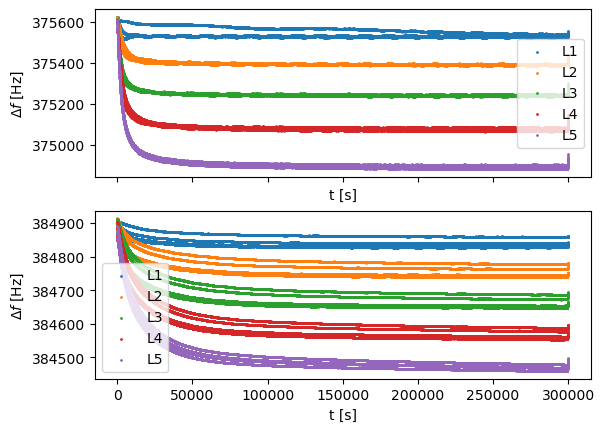

In [5]:
loading_magnitude = ['L1','L2','L3','L4','L5','L5','L4','L3','L2','L1',
                     'L1','L2','L3','L4','L5','L5','L4','L3','L2','L1'] #,'L1','L2','L3','L4','L5','L5','L4','L3','L2','L1'
# colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2',
#  '#7f7f7f', '#bcbd22', '#17becf']
colors = ['tab:blue','tab:orange','tab:green','tab:red','tab:purple']
unique_mags = sorted(list(set(loading_magnitude)))

print(unique_mags.index(loading_magnitude[5]))

fig, axs2 = plt.subplots(len(output),1,sharex=True)

grouped_sets = []
for (out,ax) in zip(output,axs2):
    load = out[1]
    # print(len(load))
    load_group = [[], [], [], [], []]
    # print(load[0][:,0])
    print(len(load_group))
    for i, lm in enumerate(loading_magnitude):
        load_index = unique_mags.index(lm)
        l = load[i]
        l[:,0] = l[:,0]-l[:,0][0]
        # print(l.shape)
        load_group[load_index].append(l)
        # print([len(L) for L in load_group])
    grouped_sets.append(load_group)
    for i,gp in enumerate(load_group):
        # print(len(load_group))
        l = np.vstack(gp)
        # print(i)
        print(l.shape)
        _ = ax.scatter(l[:,0],l[:,1],c=colors[i],s=1,label=unique_mags[i])
    ax.set_xlabel('t [s]')
    ax.set_ylabel(r'$\Delta f$ [Hz]')
    ax.legend()

# plt.ylabel('Frequency [Hz]')
plt.show()

## Now to start fitting

In [6]:
import scipy.optimize as sciopt
# import multiprocessing
# from optimparallel import minimize_parallel

import import_ipynb
from notebooks import diffusionModel as diffmod

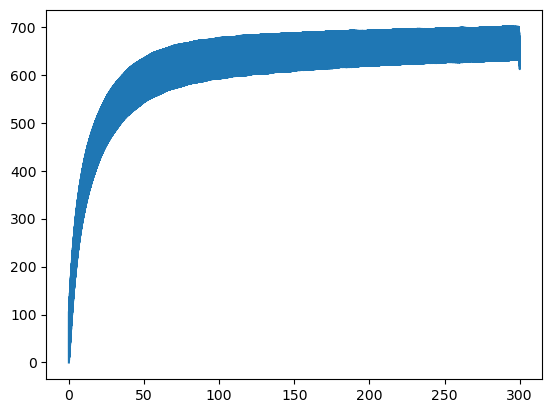

In [7]:
data = np.vstack(grouped_sets[1][3]) #takes all of the samples at a specific loading, and stacks them together
sort_idx = np.argsort(data[:,0])
data = data[sort_idx,:]
t_full = data[:,0]/1000
df_full = data[:,1]-np.max(data[:,1]) #normalize(ish)

## eqn. (4)
dm_full = -df_full*2

plt.plot(t_full,dm_full)#,s=1)
# plt.xlim(0,1)
plt.show()

                             Time [ms]             df
datetime                                             
1970-01-01 00:00:00.000      39.400000  384874.739200
1970-01-01 00:00:00.100     144.142857  384867.419000
1970-01-01 00:00:00.200     242.500000  384868.694500
1970-01-01 00:00:00.300     339.875000  384866.090125
1970-01-01 00:00:00.400     437.250000  384863.350125
...                                ...            ...
1970-01-01 00:04:59.600  299644.500000  384573.201375
1970-01-01 00:04:59.700  299746.000000  384575.486750
1970-01-01 00:04:59.800  299842.000000  384576.632429
1970-01-01 00:04:59.900  299948.000000  384580.145556
1970-01-01 00:05:00.000  300051.714286  384586.567286

[3001 rows x 2 columns]


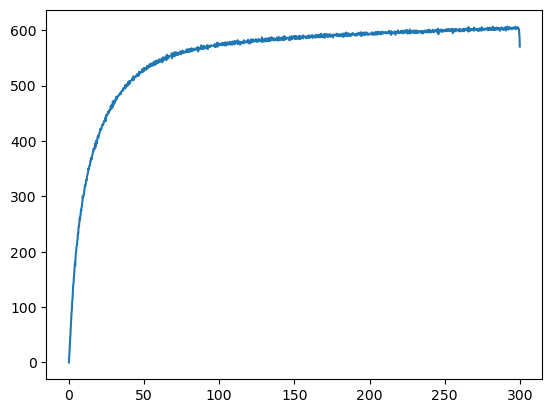

In [8]:
##resample
df2 = pd.DataFrame({'Time [ms]': data[:,0],'df': data[:,1]})
df2['datetime'] = pd.to_datetime(df2['Time [ms]'],unit='ms')
df2 = df2.set_index('datetime')

# print(df2)
print(df2.resample('0.1s').mean())
resample_df2 = df2.resample('0.2s').mean()

t = resample_df2['Time [ms]'].to_numpy(dtype='float32',copy=True)/1000 #seconds
t = t-np.min(t)
df = resample_df2['df'].to_numpy(dtype='float32',copy=True)
df = df-np.max(df) #zeroed

dm = -df*2

plt.plot(t,dm)#,s=1)
# plt.xlim(0,2)
plt.show()

2.9999999999999997e-12


<string>:8: RuntimeWarning: divide by zero encountered in divide


606.625


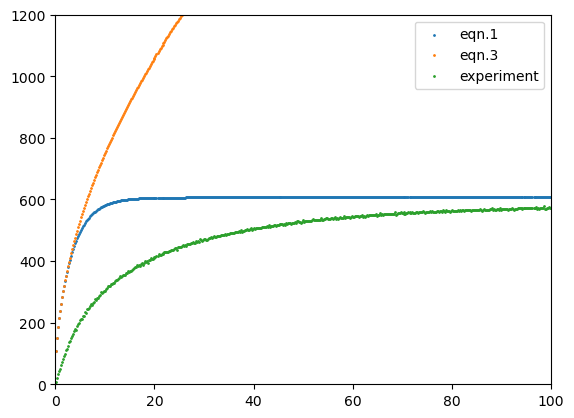

In [9]:
##test start conditions
A = np.max(dm)#490 #amplitude
D = 3e-8/(100**2) #m^/s diffusion coeff
D1 = D
D3 = D
D_sim = D*1e14
#arguments
h = 5e-6 #meters, actual height of a hammerhead is ~5 um

print(D)
model_1 = diffmod.eqn1(D1,A,h,t)
model_3 = diffmod.eqn3(D3,A,h,t)
# model_curve = diffmod.eqn3(D,A,h,t)
plt.scatter(t,model_1,s=1,label="eqn.1")
plt.scatter(t,model_3,s=1,label='eqn.3')
plt.scatter(t,dm,s=1,label='experiment')
plt.ylim(0,1200)
plt.xlim(0,100)
plt.legend()
print(A)
plt.show()

In [10]:

def residual_eqn1(D,A,h,t,dm):#(D,A,h,t,f):
    D = D*1e-14
    attempt = diffmod.eqn1(D,A,h,t)
    diff = np.diff(np.vstack((dm,attempt)),axis=0).squeeze()
    rms_diff = np.sqrt(np.mean(np.square(diff)))
    # print(diff.shape,dm.shape,attempt.shape)
    # print(rms_diff,D*1e14)
    return rms_diff

def residual_eqn3(D,A,h,t,dm):#(D,A,h,t,f):
    D = D*1e-14
    
    attempt = diffmod.eqn3(D,A,h,t)
    diff = np.diff(np.vstack((dm,attempt)),axis=0).squeeze()
    rms_diff = np.sqrt(np.mean(np.square(diff)))
    # print(diff.shape,dm.shape,attempt.shape)
    # print(rms_diff,D*1e14)
    return rms_diff


In [11]:
#fit Diffusion to resampled data, assuming A is the maximum f for the resampled data
res1 = sciopt.minimize(residual_eqn1,D_sim, bounds=[(0.1,10000)],args=(A,h,t,dm))
res3 = sciopt.minimize(residual_eqn3,D_sim, bounds=[(0.1,10000)],args=(A,h,t,dm))

  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 17.02180257984573
        x: [ 4.022e+01]
      nit: 7
      jac: [-7.105e-07]
     nfev: 36
     njev: 18
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>
  message: CONVERGENCE: NORM OF PROJECTED GRADIENT <= PGTOL
  success: True
   status: 0
      fun: 130.79770568690395
        x: [ 1.059e+01]
      nit: 7
      jac: [ 0.000e+00]
     nfev: 34
     njev: 17
 hess_inv: <1x1 LbfgsInvHessProduct with dtype=float64>


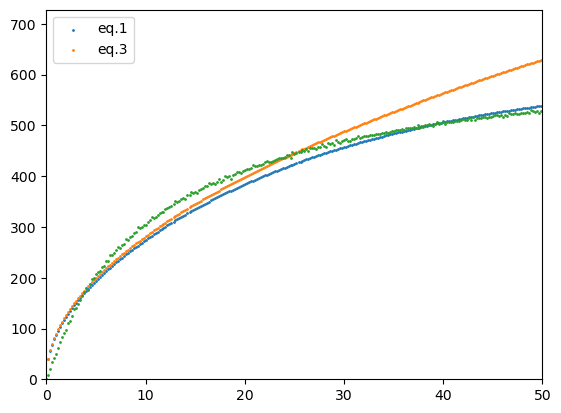

In [12]:

print(res1)
D_eff1 = res1.x[0]*1e-14
# A_eff1 = res1.x[1]

print(res3)
D_eff3 = res3.x[0]*1e-14
# A_eff3 = res3.x[1]

# model_1 = diffmod.eqn1(D_eff1,A_eff1,h,t)
# model_3 = diffmod.eqn3(D_eff3,A_eff3,h,t)
model_1 = diffmod.eqn1(D_eff1,A,h,t)
model_3 = diffmod.eqn3(D_eff3,A*2,h,t)
# model_curve = diffmod.eqn3(D,A,h,t)
plt.scatter(t,model_1,s=1,label='eq.1')
plt.scatter(t,model_3,s=1,label='eq.3')
plt.scatter(t,dm,s=1)
plt.ylim(0,A*1.2)
plt.legend()
plt.xlim(0,50)
plt.show()

the f_max being used now is 303.3125 Hz
[0.         0.20865808 0.40509558 0.6135294  0.82178307 1.0196038
 1.2162206  1.4174081  1.6227206  1.8215955  2.0212708  2.216404
 2.407004   2.6088457  2.8102708  3.0119708  3.2174706  3.4234083
 3.6295958  3.8352041  4.027204   4.2143273  4.4085956  4.6180587
 4.8196135  5.016882   5.225783   5.4194036  5.616783   5.8126707
 6.0174117  6.2208037  6.414337   6.618033   6.823533   7.021737
 7.2179375  7.4105372  7.610408   7.811204   8.016765   8.227138
 8.422533   8.620471   8.819096   9.020096   9.2078285  9.406721
 9.615409  ]


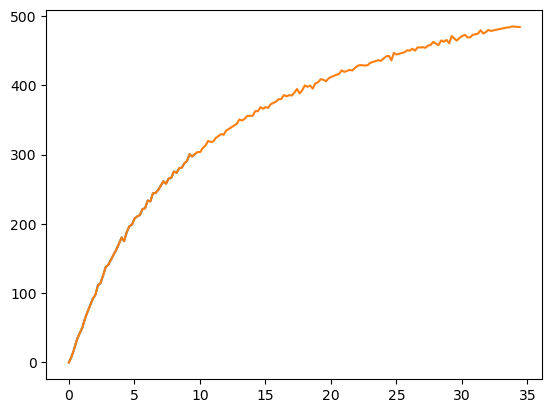

In [13]:
#take new samples of t and dm to fit to, this time, follow the paper's recommendations. For this case, assume f_max is the average
df_max = np.max(np.abs(df)) #resampled df
# df = data[:,1]-np.max(data[:,1])
print(f'the f_max being used now is {df_max} Hz')

lt50pct_fmax_idx = np.where(df>-(0.5*df_max))[0]
lt80pct_fmax_idx = np.where(df>-(0.8*df_max))[0]

lt50pct_fmax = np.vstack([t[lt50pct_fmax_idx],
                          dm[lt50pct_fmax_idx]])
lt80pct_fmax = np.vstack([t[lt80pct_fmax_idx],
                          dm[lt80pct_fmax_idx]])

# print(data)
print(lt50pct_fmax[0,:])

plt.plot(lt50pct_fmax[0,:],lt50pct_fmax[1,:])
plt.plot(lt80pct_fmax[0,:],lt80pct_fmax[1,:])
plt.show()

In [14]:
#fit Diffusion via equation (1) to resampled data, assuming A is the maximum f for the resampled data
res1 = sciopt.minimize(residual_eqn1,D*1e14, bounds=[(0.1,1000)],args=(A,h,lt80pct_fmax[0,:],lt80pct_fmax[1,:]))
res3 = sciopt.minimize(residual_eqn3,D*1e14, bounds=[(0.1,1000)],args=(A,h,lt50pct_fmax[0,:],lt50pct_fmax[1,:]))

## technically, the paper does a polynomial fit

to sqrt(t) vs df/df_max, for $0\leq x \leq f_{max}/2$ and solves for D, where:

$$p = 2f_{max} \frac{2}{h}\sqrt{\frac{D}{\pi}}$$
$$D = \left(\frac{hp}{4f_{max}}\right)^2\pi$$

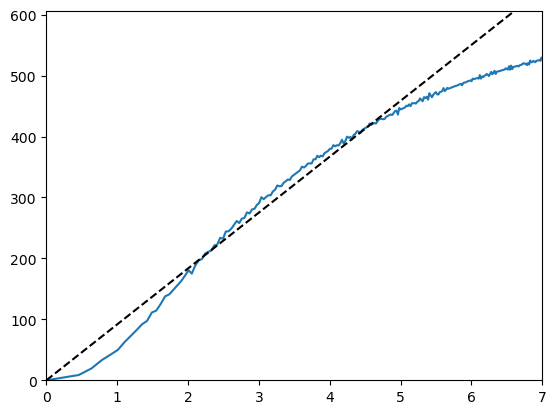

In [15]:
sqrt_t = np.sqrt(lt50pct_fmax[0,:])

def f(x,a):
    return x*a

popt,pcov = sciopt.curve_fit(f,sqrt_t,lt50pct_fmax[1,:])

p = popt[0]

D_eff3_polyfit = ((p*h/(4*df_max))**2)*np.pi

# plt.plot(sqrt_t,lt50pct_fmax[1,:])
# plt.plot(sqrt_t,np.polyval((p,0),sqrt_t),'k--')
plt.plot(np.sqrt(t),dm)
plt.plot(np.sqrt(t),np.polyval((p,0),np.sqrt(t)),'k--')
plt.xlim(0,7)
plt.ylim(0,df_max*2)
plt.show()

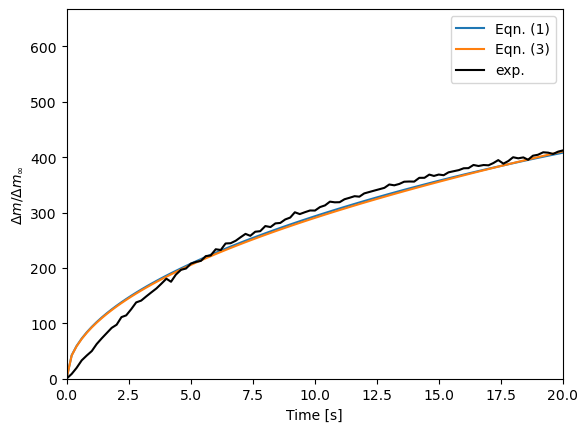

Eqn. 1 D= 45.903178156296136x10^-10 cm^2/s; Eqn. 2 D=44.92497852729991x10^-10  cm^2/s


In [16]:

# print(res1)
D_eff1 = res1.x[0]*1e-14

# print(res3)
D_eff3_sciopt = res3.x[0]*1e-14
D_eff3 = D_eff3_sciopt

model_1 = diffmod.eqn1(D_eff1,A,h,t)

model_3_eqn = diffmod.eqn3(D_eff3,A,h,t)
model_3_poly = np.polyval((p,0),np.sqrt(t))

plt.plot(t,model_1,label='Eqn. (1)')
# plt.plot(t,model_3_eqn,label='Eqn. (3) scipy minimize')
plt.plot(t,model_3_poly,label='Eqn. (3)')
plt.plot(t,dm,'k-',label='exp.')

plt.ylim(0,1.1*df_max*2)
plt.xlim(0,20)
plt.xlabel('Time [s]')
plt.ylabel(r'$\Delta m/\Delta m_{\infty}$')
plt.legend()
plt.show()
# print(D_eff3_sciopt,D_eff1_polyfit)
print(f'Eqn. 1 D= {D_eff1*(100**2)*(10**10)}x10^-10 cm^2/s; Eqn. 2 D={D_eff3*(100**2)*(10**10)}x10^-10  cm^2/s')
# print(dm[90:100])
# print(lt50pct_fmax.shape)
# print(lt50pct_fmax[1,90:100])
# print(t[:11])
# print(lt50pct_fmax[0,:])